In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations, product
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os

from tqdm import tqdm
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing


device = torch.device('cuda')
plt.style.use('default')

import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 18

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
files = sorted(list(os.walk('Stocks'))[0][2])

data = []
min_length = 504

for i in range(len(files[:])):
    try:
        temp = pd.read_csv(f'Stocks/{files[i]}')['Close'].values
        # l = len(temp)
        # if l < min_length:
        #     min_length = l

        data.append(temp)

    except:
        continue


data_new = []

for i in range(len(data)):
    if len(data[i]) >= min_length:
        data_new.append(data[i][:min_length])

data = np.array(data_new)
scaler = MinMaxScaler((-1, 1))

data = scaler.fit_transform(data.T).T

data = torch.tensor(data.astype('float32'))[:50]

# files = sorted(list(os.walk('/content/drive/MyDrive/Stocks'))[0][2])

# data = []
# min_length = 504

# for i in range(len(files[:])):
#     try:
#         temp = pd.read_csv(f'/content/drive/MyDrive/Stocks/{files[i]}')['Close'].values
#         data.append(temp)

#     except:
#         continue


# data_new = []

# for i in range(len(data)):
#     if len(data[i]) >= min_length:
#         data_new.append(data[i][:min_length])

# data = np.array(data_new)
# scaler = MinMaxScaler((-1, 1))

# data = scaler.fit_transform(data.T).T
# data = torch.tensor(data.astype('float32'))[:50]

In [ ]:
# data = np.load('/content/drive/MyDrive/Stocks/Sine_dataset.npy')
# scaler = MinMaxScaler((-1, 1))

# data = torch.tensor(scaler.fit_transform(data.T).T.astype('float32'))

In [ ]:
data.size()

torch.Size([50, 504])

In [ ]:
smooth_fun = lambda x: torch.nn.functional.conv1d(x.to(device), torch.ones(21).to(device).unsqueeze(0).unsqueeze(0)/21, padding='same').flatten().to(device)
smooth_fun_vectorized = lambda x: torch.vmap(smooth_fun)(x)
trend_data = smooth_fun_vectorized(data.unsqueeze(1))

In [ ]:
torch.vmap(smooth_fun_vectorized)(data.unsqueeze(1).expand(len(data), 5, len(data[0])).unsqueeze(2)).size()

torch.Size([50, 5, 504])

In [ ]:
smooth_fun_force = lambda x: torch.nn.functional.conv1d(x.to(device), torch.ones(7).to(device).unsqueeze(0).unsqueeze(0)/7, padding='same').flatten().to(device)
smooth_fun_vectorized_force = lambda x: torch.vmap(smooth_fun_force)(x)

In [ ]:
T = len(data[0])

In [ ]:
# trend_data = []
# seasonal_data = []

# for i in range(data.shape[0]):
#     seas_decomp = seasonal_decompose(pd.DataFrame(data[i], index=pd.date_range(start='01-01-2024', periods=len(data[i]), freq='D')),
#                                      model='additive', extrapolate_trend=True, two_sided=True, period=21)

#     trend_data.append(seas_decomp.trend.values)
#     seasonal_data.append(seas_decomp.seasonal.values)
#     # exp_smooth = ExponentialSmoothing(data[i].numpy(), initialization_method="estimated").fit(smoothing_level=0.03)
#     # trend_data.append(exp_smooth.fittedvalues)

# trend_data = np.array(trend_data).astype('float32')
# trend_data = torch.tensor(trend_data)

# seasonal_data = np.array(seasonal_data).astype('float32')
# seasonal_data = torch.tensor(seasonal_data)

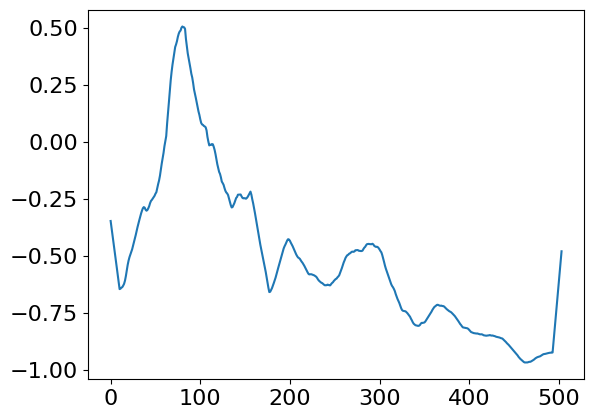

In [ ]:
plt.plot(trend_data.cpu()[:1].T)
plt.show()

In [ ]:
start_point = data[:, 0].view(-1, 1, 1).to(device)
end_point = data[:, -1].view(-1, 1, 1).to(device)
labels = torch.tensor(torch.arange(len(data)), dtype=torch.float32).view(-1, 1, 1).to(device)

<ipython-input-9-7ea43929cf3b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(torch.arange(len(data)), dtype=torch.float32).view(-1, 1, 1).to(device)


In [ ]:
# exponent = torch.exp(torch.linspace(0, 2, 25))
# exponent = exponent/exponent.max()
# endp_mask = torch.hstack([torch.zeros(252 - int(0.1 * 252)), exponent * torch.ones(int(0.1 * 252))]).repeat(end_point.size(0), 32, 1).to(device)


In [ ]:
def window_slice(data: np.array, seq_len):
    ori_data = data[::]
    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len + 1):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

def hankel_matrix(time_series, ws):
    hankel_mat_arr = []
    for ts in time_series:
        hankel_mat_arr.append(torch.stack(window_slice(ts, ws)))

    return torch.stack(hankel_mat_arr)


class TrendAttention(nn.Module):
    def __init__(self, ws, laten_dim, n_rows, out_ch):
        super(TrendAttention, self).__init__()

        self.num_heads = 4
        self.attn_dim = 64 * self.num_heads


        self.conv = nn.Conv1d(n_rows, self.attn_dim, kernel_size=3, padding='same')
        self.fc_q = nn.Linear(ws, self.attn_dim)
        self.fc_k = nn.Linear(ws, self.attn_dim)
        self.fc_v = nn.Linear(ws, self.attn_dim)
        self.act = nn.SiLU()

        self.mh_att = nn.MultiheadAttention(self.attn_dim, self.num_heads, dropout=0.2, batch_first=True)

        self.conv_att = nn.Conv1d(self.attn_dim, out_ch, kernel_size=3, padding='same')
        self.fc_att = nn.Linear(self.attn_dim, laten_dim)

        # self.layer_norm = nn.LayerNorm(64)

    def forward(self, x):
        out = self.act(self.conv(x))
        # out = self.layer_norm(out)

        x_q = self.fc_q(out)
        x_k = self.fc_k(out)
        x_v = self.fc_v(out)

        out = self.mh_att(x_q, x_k, x_v)[0]
        out = self.fc_att(self.conv_att(out))

        return out


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings).to(device)
        embeddings = 1000 * time.float().unsqueeze(1) * embeddings.unsqueeze(0)
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        # embeddings[0::2] = np.sin(embeddings[0::2])
        # embeddings[1::2] = np.cos(embeddings[1::2])
        if self.dim % 2 == 1:  # zero pad if odd dimension
            embeddings = F.pad(embeddings, (0, 1))

        return embeddings


def forceMask(T, t):
    perc = int(0.3 * T)
    half_perc = perc // 2

    # num_zeros = (T - perc) // 2
    num_ones_half = half_perc
    exponent_f = torch.exp(torch.linspace(0, 1, num_ones_half))
    exponent_f = exponent_f/exponent_f.max()
    exponent_inv_f = exponent_f.flip(0)

    window = torch.hstack([exponent_f * torch.ones(num_ones_half), (exponent_inv_f * torch.ones(num_ones_half))[1:]])

    if t < half_perc:
        window = window[half_perc - t - 1:]
        mask = torch.hstack([window, torch.zeros(T - len(window))])

    elif t > (T - half_perc):
        window = window[:-(half_perc - (T - t))]
        mask = torch.hstack([torch.zeros(T - len(window)), window])

    else:
        mask = torch.hstack([torch.zeros(t - half_perc + 1), window, torch.zeros(T - t - half_perc)])

    return mask

In [ ]:
# time_encoder = SinusoidalPositionEmbeddings(128)
# arr = []
# for t in range(0, 504):
#   time_emb = time_encoder(torch.tensor(t/504).unsqueeze(0).to(device)).to(device)
#   arr.append(time_emb.squeeze().cpu().detach())

# sns.heatmap(arr)

In [ ]:
def checkpoint(model, optim, epoch, loss):
    torch.save({'model': model.state_dict(),
                'optimizer': optim.state_dict(),
                'epoch': epoch,
                'loss': loss
                }, f'/content/drive/My Drive/Checkpoints_diffusion/Checkpoint_epoch-{epoch}.pth')


def resume(model, optim, epoch):
    check = torch.load(f'/content/drive/My Drive/Checkpoints_diffusion/Checkpoint_epoch-{epoch}.pth', weights_only=True)
    model.load_state_dict(check)
    optim.load_state_dict(check)
    # epoch = check['epoch']
    loss = check['loss']

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)

        self.act = nn.ReLU()

        self.drop1 = nn.Dropout(0.2)
        self.drop2 = nn.Dropout(0.2)

    def forward(self, x):
        skip = x
        out = self.conv1(x)
        out = self.act(out)
        out = self.bn1(out)

        out = out + skip
        out = self.drop1(out)

        skip2 = out
        out = self.conv2(out)
        out = self.act(out)
        out = self.bn2(out)

        out = out + skip2
        out = self.drop2(out)

        return out

# VAE model definition
class VAE(nn.Module):
    def __init__(self, input_channels=1, seq_length=128, latent_dim=16, hidden_channels=32):
        super(VAE, self).__init__()
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels


        self.enc_conv1 = nn.Conv1d(input_channels, hidden_channels, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm1d(hidden_channels)
        self.enc_res1 = ResidualBlock(hidden_channels)

        self.enc_conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm1d(hidden_channels)
        self.enc_res2 = ResidualBlock(hidden_channels)



        conv_out_length = seq_length // 4

        self.dim1 = 252
        self.dim2 = 126
        # self.dim1 = 500
        # self.dim2 = 250

        # self.control_attn1 = TrendAttention(WINDOW_SIZE, self.dim1, hankel_td.size(1), hidden_channels).to(device)
        # self.control_attn2 = TrendAttention(WINDOW_SIZE, 2 * conv_out_length, hankel_td.size(1), hidden_channels)
        # self.control_attn3 = TrendAttention(WINDOW_SIZE, 504, hankel_td.size(1), hidden_channels)
        # self.control_conv = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
        #                                   nn.SiLU(),
        #                                   nn.Linear(34, self.dim1))
        self.dim_trend_recon = torch.ceil(torch.tensor(T / STEP_SIZE_TREND)).long()
        # self.control_conv = nn.Sequential(nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding='same'),
        #                                   nn.SiLU(),
        #                                   nn.Linear(self.dim_trend_recon, self.dim1),
        #                                   nn.Sigmoid())
        self.control_conv = nn.Sequential(nn.Linear(self.dim_trend_recon, self.dim1),
                                          nn.Sigmoid())

        self.sig = nn.Sigmoid()
        # self.fc_mu = nn.Sequential(nn.Linear(hidden_channels * conv_out_length, latent_dim),
        #                            nn.SiLU(),
        #                            nn.Linear(latent_dim, latent_dim))

        # self.fc_logvar = nn.Sequential(nn.Linear(hidden_channels * conv_out_length, latent_dim),
        #                            nn.SiLU(),
        #                            nn.Linear(latent_dim, latent_dim))

        # self.fc_decode = nn.Sequential(nn.Linear(latent_dim, latent_dim),
        #                            nn.SiLU(),
        #                            nn.Linear(latent_dim, hidden_channels * conv_out_length))

        self.fc_mu = nn.Sequential(nn.Linear(hidden_channels * conv_out_length, latent_dim),
                                   )

        self.fc_logvar = nn.Sequential(nn.Linear(hidden_channels * conv_out_length, latent_dim),
                                   )

        self.fc_decode = nn.Sequential(nn.Linear(latent_dim, hidden_channels * conv_out_length))



        self.dec_conv1 = nn.ConvTranspose1d(hidden_channels, hidden_channels, kernel_size=3,
                                              stride=2, padding=1, output_padding=1)
        self.dec_bn1 = nn.BatchNorm1d(hidden_channels)
        self.dec_res1 = ResidualBlock(hidden_channels)

        self.dec_conv2 = nn.ConvTranspose1d(hidden_channels, hidden_channels, kernel_size=3,
                                              stride=2, padding=1, output_padding=1)
        self.dec_res2 = ResidualBlock(hidden_channels)
        self.dec_conv3 = nn.ConvTranspose1d(hidden_channels, input_channels, kernel_size=1)

        self.act = nn.SiLU()

        # self.fc_end_point1 = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
        #                                   nn.SiLU(),
        #                                   nn.Linear(1, self.dim2)
        #                                   )

        self.fc_end_point = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(1, self.dim1),
                                        #   nn.Sigmoid()
                                          )
        self.fc_start_point = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(1, self.dim1),
                                        #   nn.Sigmoid()
                                          )

        label_emb_size = 64
        self.label_embedding = nn.Embedding(len(data), label_emb_size) ### change len(data)

        self.enc_label1 = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(label_emb_size, self.dim1),
                                          nn.Sigmoid())

        self.enc_label2 = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(label_emb_size, self.dim2))

        self.dec_label1 = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(label_emb_size, self.dim2),
                                          nn.Sigmoid())

        self.dec_label2 = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                          nn.SiLU(),
                                          nn.Linear(label_emb_size, self.dim1))

        self.norm_control = nn.LayerNorm(self.dim1)
        self.fc_z1 = nn.Sequential(nn.Linear(latent_dim, self.dim1))
                                #    nn.Sigmoid())
        self.fc_z2 = nn.Linear(latent_dim, T)


        self.time_encoder = SinusoidalPositionEmbeddings(2**7)
        self.proj_ft = nn.Linear(2**7, T)
        self.proj_fv = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                     nn.SiLU(),
                                     nn.Linear(1, T),
                                     nn.SiLU(),
                                     nn.Conv1d(hidden_channels, 1, kernel_size=3, padding='same'))

        self.conv_force_proj = nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same')
        self.conv_force_point = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
                                              nn.SiLU(),
                                              nn.BatchNorm1d(hidden_channels),
                                              nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding='same'),
                                              nn.SiLU(),
                                              nn.Conv1d(hidden_channels, 1, kernel_size=3, padding='same'))
        self.residual_force = ResidualBlock(hidden_channels)


    def encode(self, x, l):
        label_emb = self.label_embedding(l.long().squeeze(1))
        # skip = x
        x = self.enc_conv1(x)
        x = self.act(x)
        # x = self.enc_bn1(x)
        x = self.enc_res1(x) + 0.2 * self.enc_label1(label_emb)


        x = self.enc_conv2(x)
        x = self.act(x)
        # x = self.enc_bn2(x)
        x = self.enc_res2(x)


        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def decode(self, z, l, u, endp, startp, ft, fv, flag_v):
        label_emb = self.label_embedding(l.long().squeeze(1))
        conv_out_length = self.seq_length // 4

        x = self.fc_decode(z)
        x = x.view(z.size(0), self.hidden_channels, conv_out_length)

        x = x + 0.2 * self.dec_label1(label_emb)

        x = self.dec_conv1(x)
        x = self.act(x)
        # x = self.dec_bn1(x)
        x = self.dec_res1(x)



        indexes = torch.arange(0, T, STEP_SIZE_TREND)

        # print(u.size())
        # control_emb = self.control_attn1(u[:,:,indexes]).squeeze(1) #(B, hidden_channels, cond_dim)
        control_emb = self.control_conv(u[:,:,indexes].repeat(1, self.hidden_channels, 1))
        # print(control_emb.size())

        mask_percent = 0.3
        exponent = torch.exp(torch.linspace(0, 1, int(mask_percent * self.dim1)))
        exponent = exponent/exponent.max()
        exponent_inv = exponent.flip(0)
        endp_mask = torch.hstack([torch.zeros(self.dim1 - int(mask_percent * self.dim1)),\
                                  exponent * torch.ones(int(mask_percent * self.dim1))]).repeat(endp.size(0), self.hidden_channels, 1).to(device)
        startp_mask = torch.hstack([exponent_inv * torch.ones(int(mask_percent * self.dim1)),\
                                  torch.zeros(self.dim1 - int(mask_percent * self.dim1))]).repeat(startp.size(0), self.hidden_channels, 1).to(device)

        x = x + endp_mask * torch.vmap(smooth_fun_vectorized_force)(self.fc_end_point(endp).unsqueeze(2)) +\
                startp_mask * torch.vmap(smooth_fun_vectorized_force)(self.fc_start_point(startp).unsqueeze(2)) + \
                0.8 * control_emb + self.fc_z1(z.unsqueeze(1).repeat(1, self.hidden_channels, 1))



        x = self.dec_conv2(x)
        x = self.dec_res2(x) + self.fc_z2(z.unsqueeze(1).repeat(1, self.hidden_channels, 1))


        # time_emb = self.time_encoder(ft.unsqueeze(0).to(device)/T).to(device) # (1, 1, T)
        # time_emb = time_emb.squeeze(0).expand(z.size(0), 2**7)  # (B, T)


        # force_emb = self.proj_ft(time_emb) + self.proj_fv(fv.unsqueeze(1)).squeeze(1)   # (B, T)
        # force_mask = forceMask(T, ft.clone().long().detach().flatten().cpu().numpy()[0]).to(device)
        # force_emb = force_mask * self.conv_force_point(force_emb.unsqueeze(1))   # (B, 1, T)
        time_emb = self.time_encoder(ft.unsqueeze(0).to(device)/T).to(device) # (1, 1, T)
        time_emb = time_emb.squeeze(0).expand(x.size(0), 2**7)  # (B, T)


        force_emb = self.proj_ft(time_emb) + self.proj_fv(fv.unsqueeze(1)).squeeze(1)   # (B, T)
        force_mask = forceMask(T, ft.clone().long().detach().flatten().cpu().numpy()[0]).to(device)

        # force_emb = force_mask * torch.vmap(smooth_fun_vectorized_force)(self.conv_force_point(force_emb.unsqueeze(1)).unsqueeze(2))   # (B, 1, T)
        # force_emb = force_mask * self.conv_force_point(self.residual_force(self.conv_force_proj(force_emb.unsqueeze(1))))
        force_emb = force_mask * self.conv_force_point(force_emb.unsqueeze(1))
        out_f = force_emb

        # return out_f + (1 - force_mask) * x

        x = self.dec_conv3(x)      # (B, 1, T)
        x = x #+ force_emb  # (B, 1, T)

        return flag_v * ( (1 - force_mask) * x + out_f ) + (1 - flag_v) * x



    def forward(self, x, l, control, endp, startp, ft, fv, flag_v):
        mu, logvar = self.encode(x, l)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, l, control, endp, startp, ft, fv, flag_v)
        return recon_x, mu, logvar



def vae_loss(recon_x, x, mu, logvar, beta, endp, startp, u, ft, fv, gamma):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = torch.mean( -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp() , dim=1) )

    smooth_synth_x = torch.vmap(smooth_fun)(recon_x).unsqueeze(1)
    indexes = torch.arange(0, len(data[0]), STEP_SIZE_TREND)
    smooth_synth_x = smooth_synth_x[:, :, indexes]
    trend_loss = F.mse_loss(smooth_synth_x, u[:, :, indexes], reduction='mean')


    endpoint_loss = F.mse_loss(recon_x[:, :, -1], endp.squeeze(1), reduction='mean')
    startpoint_loss = F.mse_loss(recon_x[:, :, 0], startp.squeeze(1), reduction='mean')

    forceValue_loss = F.mse_loss(recon_x[:, :, ft[0]], fv, reduction='mean')

    loss_dict = {'Reconstruction': recon_loss, 'KL': kl_loss, \
                 'Trend': trend_loss, 'EP': endpoint_loss, 'SP': startpoint_loss,
                 'FP': forceValue_loss}

    return recon_loss + beta * kl_loss + 0.1 * trend_loss + 0.1 * endpoint_loss + 0.1 * startpoint_loss + gamma * forceValue_loss, loss_dict
# + gamma * forceValue_loss

# Training procedure
def train_vae(model, train_loader, num_epochs=500, learning_rate=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=2e-4)
    beta_sch = torch.cat([torch.tensor(np.linspace(0.0, 0.005, num_epochs//2)), torch.tensor(np.linspace(0.005, 0.05, num_epochs//2))]).float().to(device)
    fv_loss_sch = torch.cat([torch.tensor(np.linspace(0.0, 0.1, num_epochs//2)), torch.tensor(np.linspace(0.1, 0.1, num_epochs//2))]).float().to(device)


    epochs = tqdm(range(num_epochs))

    losses = []
    losses_dict = []

    model.train()
    for epoch in epochs:
        epoch_loss = 0

        for data, label, control, endp, startp in train_loader:
            data = data.to(device)

            force_times = torch.randint(0, T, (1,))    # (1)
            force_values = data[:, :, force_times[0]]   # (B, 1)
            flag_v = torch.randint(0, 2, (data.size(0), 1, 1)).to(device)

            recon_data, mu, logvar = model(data, label, control, endp, startp, force_times, force_values, flag_v)
            loss, loss_dict = vae_loss(recon_data, data, mu, logvar, beta_sch[epoch], endp, startp, control, force_times, force_values, fv_loss_sch[epoch])

            optimizer.zero_grad()
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()


        avg_loss = epoch_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        losses_dict.append(loss_dict)

        # print(optimizer.param_groups[0]['lr'])
        if epoch % 100 == 0:
            epochs.set_description(f'Average Loss: {avg_loss:.4f}')
        # if epoch % 500 == 0:
            # checkpoint(model, optimizer, epoch, avg_loss)

    # print(scheduler.get_last_lr())
    return losses, losses_dict

In [ ]:
class DatasetCustom(torch.utils.data.Dataset):
    def __init__(self, data, label, control, end_point, start_point):
        self.data = data
        self.control = control
        self.end_point = end_point
        self.start_point = start_point
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return [self.data[idx], self.label[idx], self.control[idx], self.end_point[idx], self.start_point[idx]]

In [ ]:
# torch.arange(0, len(data[0]), STEP_SIZE_TREND).size()

In [ ]:
batch_size = 16
# num_samples = 5
seq_length = T
input_channels = 1
WINDOW_SIZE = 128
STEP_SIZE_TREND = 5

# hankel_td = hankel_matrix(trend_data, WINDOW_SIZE).to(device)
hankel_td = trend_data.unsqueeze(1).to(device)
dataset_diff = DatasetCustom(data.unsqueeze(1), labels, hankel_td, end_point, start_point)
train_loader = torch.utils.data.DataLoader(dataset_diff, batch_size=batch_size, shuffle=True)
# train_loader = torch.utils.data.DataLoader(data[:, :-1].unsqueeze(1), batch_size=batch_size, shuffle=True)

# Initialize the VAE model
model_vae = VAE(input_channels=input_channels, seq_length=seq_length, latent_dim=256, hidden_channels=32)

# Train the VAE
losses_vae, losses_vae_dict = train_vae(model_vae, train_loader, num_epochs=2000, learning_rate=1e-3)

Average Loss: 0.0018: 100%|██████████| 2000/2000 [02:54<00:00, 11.48it/s]


In [ ]:
# torch.save({'model': model_vae.state_dict(),
#                 'epoch': 1500,
#                 'loss': losses_vae
#                 }, f'/content/drive/My Drive/Checkpoints_diffusion/Model_last.pth')

# seq_length = 504
# input_channels = 1
# STEP_SIZE_TREND = 35
# hankel_td = trend_data.unsqueeze(1).to(device)
# check = torch.load(f'/content/drive/My Drive/Checkpoints_diffusion/Model.pth', weights_only=True)
# model_vae = VAE(input_channels=input_channels, seq_length=seq_length, latent_dim=128, hidden_channels=32).to(device)
# model_vae.load_state_dict(check['model'])

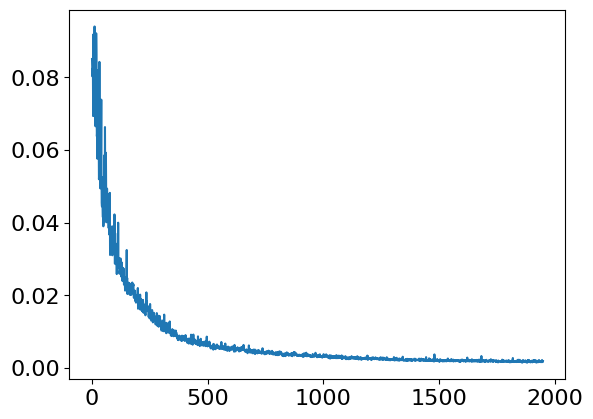

In [ ]:
plt.plot(losses_vae[50:])
plt.show()

In [ ]:
losses_dict = {'Reconstruction': [], 'KL': [], \
                 'Trend': [], 'EP': [], 'SP': [],
                 'FP': []}
for item in losses_vae_dict:
  losses_dict['Reconstruction'].append(item['Reconstruction'].item())
  losses_dict['KL'].append(item['KL'].item())
  losses_dict['Trend'].append(item['Trend'].item())
  losses_dict['EP'].append(item['EP'].item())
  losses_dict['SP'].append(item['SP'].item())
  losses_dict['FP'].append(item['FP'].item())

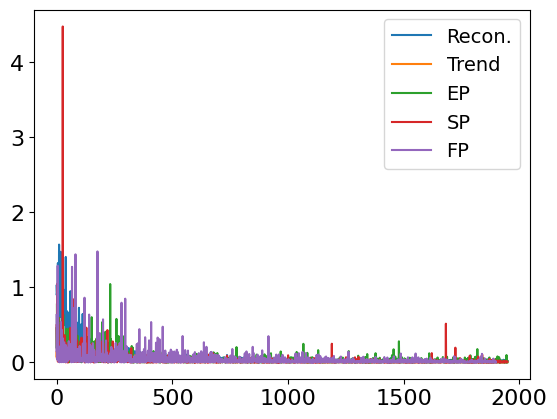

In [ ]:
plt.plot(losses_dict['Reconstruction'][50:], label='Recon.')
# plt.plot(losses_dict['KL'][50:], label='KL')
plt.plot(losses_dict['Trend'][50:], label='Trend')
plt.plot(losses_dict['EP'][50:], label='EP')
plt.plot(losses_dict['SP'][50:], label='SP')
plt.plot(losses_dict['FP'][100:], label='FP')

plt.legend()
plt.show()

In [ ]:
import time

In [ ]:
st=time.time()

model_vae.eval()

force_times = torch.randint(0, T, (1, )).to(device)
force_values = data.unsqueeze(1)[:, :, force_times[0]].to(device)
flag_v = torch.zeros((len(data), 1, 1)).to(device)

synth_vae, mu, logvar = model_vae(data.unsqueeze(1).to(device), labels, hankel_td, end_point, start_point, force_times, force_values, flag_v)
synth_vae = synth_vae.squeeze(1).detach().cpu().numpy()

et=time.time()
et-st

0.056351661682128906

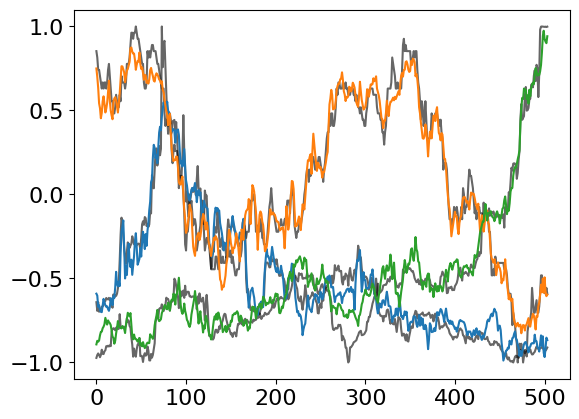

In [ ]:
plt.plot(data[:3].cpu().T, color='black', alpha=0.6)
plt.plot(synth_vae[:3].T)
plt.show()

In [ ]:
def sample(n_samples, idx, hankel_td, end_point, start_point, ft=300, fv=0.0, fv_flag=False):
    arr = []
    l = torch.tensor(idx, dtype=torch.float32).view(-1, 1, 1).to(device)

    for i in range(n_samples):
        # force_times = torch.randint(0, T, (1, )).to(device)
        force_times = torch.tensor([ft]).to(device)
        if fv_flag:
          force_values = fv + 0.0*data.unsqueeze(1)[idx, :, force_times[0]].to(device)
          flag_v = torch.ones((1, 1, 1)).to(device)
        else:
          force_values = data.unsqueeze(1)[idx, :, force_times[0]].to(device)
          flag_v = torch.zeros((1, 1, 1)).to(device)

        z = model_vae.reparameterize(mu[idx].unsqueeze(0), logvar[idx].unsqueeze(0)).detach()
        synth = model_vae.decode(z, l, hankel_td[idx].unsqueeze(0), end_point[idx].unsqueeze(1),\
                                 start_point[idx].unsqueeze(1),
                                 force_times, force_values.unsqueeze(0),
                                 flag_v).detach().cpu().squeeze(1).T.numpy()

        arr.append(synth)

    return np.hstack(arr).T

In [ ]:
# control_trend = torch.tensor(trend_data[:, 21:] + torch.cos(torch.tensor(3*2*torch.pi*np.arange(483))/483)).float()
control_trend = 0.5 * torch.tensor(trend_data +\
                      torch.cos(torch.tensor(3*2*torch.pi*np.arange(len(data[0])))/len(data[0])).to(device)).float().unsqueeze(1).to(device)

# control_trend = 0.5 * torch.tensor(trend_data + torch.linspace(-1, 1, T).to(device)).float().unsqueeze(1).to(device)

# control_trend = hankel_matrix(control_trend, WINDOW_SIZE)

# hankel_td_control = hankel_matrix(control_trend, WINDOW_SIZE).to(device)

<ipython-input-366-ff3ae2bf39c0>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  control_trend = 0.5 * torch.tensor(trend_data +\


In [ ]:
# control_trend = 1 - trend_data
# control_trend = ((control_trend - control_trend.min())/(control_trend.max() - control_trend.min())).float().unsqueeze(1)

In [ ]:
end_point_control = 0.4 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)
start_point_control = 0.3 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)

In [ ]:
# control_trend = torch.linspace(1, 0, len(trend_data[0])).repeat(10, 1)
# control_trend = hankel_matrix(control_trend, WINDOW_SIZE)

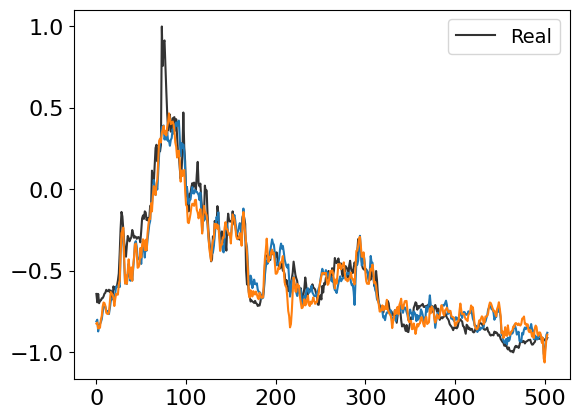

In [ ]:
idx = 0

synth_ts = sample(2, idx, hankel_td, end_point, start_point_control)

# plt.plot(control_trend[idx][0].cpu(), '-.', color='purple', alpha=0.6, label='Control')
plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

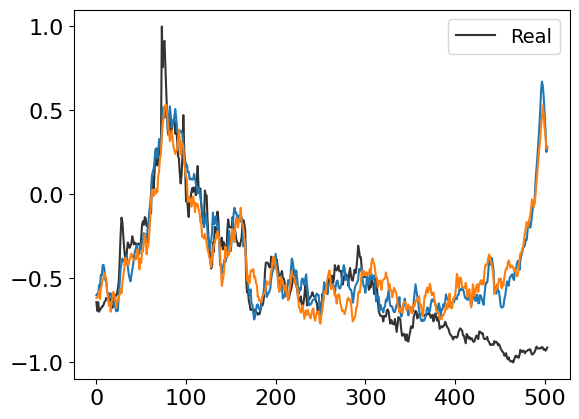

In [ ]:
idx = 0

synth_ts = sample(2, idx, hankel_td, end_point_control, start_point)

plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

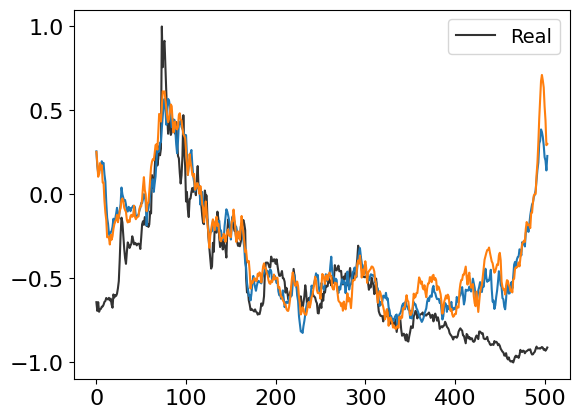

In [ ]:
idx = 0

synth_ts = sample(2, idx, hankel_td, end_point_control, start_point_control)

plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

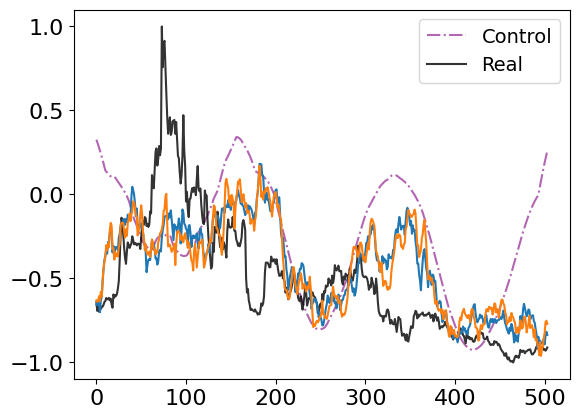

In [ ]:
idx = 0

synth_ts = sample(2, idx, control_trend, end_point, start_point)

plt.plot(control_trend[idx][0].cpu(), '-.', color='purple', alpha=0.6, label='Control')
plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

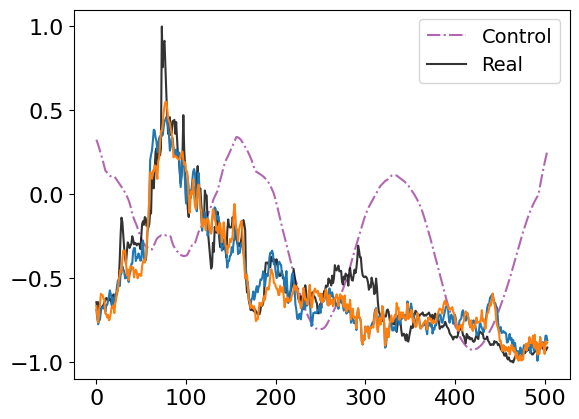

In [ ]:
idx = 0

synth_ts = sample(2, idx, hankel_td, end_point, start_point, ft=300, fv=-0.8, fv_flag=True)

plt.plot(control_trend[idx][0].cpu(), '-.', color='purple', alpha=0.6, label='Control')
plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

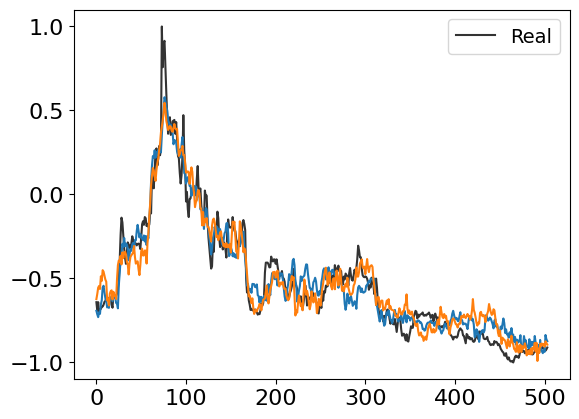

In [ ]:
idx = 0

synth_ts = sample(2, idx, hankel_td, end_point, start_point)

plt.plot(data[idx], color='black', alpha=0.8, label='Real')
plt.plot(synth_ts.T)

plt.legend()

plt.show()

In [ ]:
# class ForcePointGenerator(nn.Module):
#     def __init__(self, hidden_channels):
#       super(ForcePointGenerator, self).__init__()


#       self.time_encoder = SinusoidalPositionEmbeddings(2**7)
#       self.proj_ft = nn.Sequential(nn.Linear(2**7, T),
#                                    nn.Sigmoid())

#       self.proj_fv = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
#                                     nn.ReLU(),
#                                     nn.Linear(1, T),
#                                     nn.ReLU(),
#                                     nn.Conv1d(hidden_channels, 1, kernel_size=3, padding='same'))

#       self.conv_force_point = nn.Sequential(nn.Conv1d(1, hidden_channels, kernel_size=3, padding='same'),
#                                             nn.ReLU(),
#                                             # nn.BatchNorm1d(hidden_channels),
#                                             nn.Conv1d(hidden_channels, 1, kernel_size=3, padding='same'))

#       self.x_conv1 = nn.Sequential(nn.Conv1d(1, 1, kernel_size=3, padding='same'),
#                                   nn.ReLU(),
#                                   nn.Conv1d(1, 1, kernel_size=3, padding='same'),
#                                   nn.ReLU(),
#                                 )
#       self.x_conv2 = nn.Sequential(nn.Conv1d(1, 1, kernel_size=3, padding='same'),
#                                   nn.ReLU()
#                                 )
#       self.x_conv3 = nn.Sequential(nn.Conv1d(1, 1, kernel_size=3, padding='same'),
#                                   nn.ReLU(),
#                                   # nn.Conv1d(1, 1, kernel_size=3, padding='same'),
#                                   # nn.SiLU()
#                                 )

#     def forward(self, x, ft, fv):

#       time_emb = self.time_encoder(ft.unsqueeze(0).to(device)/T).to(device) # (1, 1, T)
#       time_emb = time_emb.squeeze(0).expand(x.size(0), 2**7)  # (B, T)


#       force_emb = self.proj_ft(time_emb) + self.proj_fv(fv.unsqueeze(1)).squeeze(1)   # (B, T)
#       force_mask = forceMask(T, ft.clone().long().detach().flatten().cpu().numpy()[0]).to(device)

#       force_emb = force_mask * torch.vmap(smooth_fun_vectorized_force)(self.conv_force_point(force_emb.unsqueeze(1)).unsqueeze(2))   # (B, 1, T)
#       # force_emb = force_mask * self.conv_force_point(force_emb.unsqueeze(1))
#       out_f = force_emb

#       # out = self.x_conv1(out_f) + x #self.x_conv1(x)
#       # out = self.x_conv2(out) + x
#       # out = out + self.x_conv2(out_f)
#       # out = out + self.x_conv3(out_f)

#       return out_f + (1 - force_mask) * x

In [ ]:
# def train_force(num_epochs, train_loader):
#     model = ForcePointGenerator(32).to(device)

#     optimizer = optim.AdamW(model.parameters(), lr=1e-3)
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=2e-4)
#     epochs = tqdm(range(num_epochs))

#     losses = []

#     half_perc = int(0.3 * T)//2

#     model.train()
#     for epoch in epochs:
#         epoch_loss = 0

#         for data, label, control, endp, startp in train_loader:
#             data = data.to(device)


#             force_times = torch.randint(0, T, (1,))    # (1)
#             force_values = data[:, :, force_times[0]] + 0.01 * torch.randn((data.size(0), 1), device=device)   # (B, 1)

#             recon_data = model(data, force_times, force_values)


#             # if force_times + half_perc > T:
#             #     loss = 0.0 * torch.mean((data[:,:,:force_times - half_perc] - recon_data[:,:,:force_times - half_perc])**2).to(device) \
#             #         + torch.mean((force_values - recon_data[:,:,force_times[0]])**2).to(device)

#             # elif force_times - half_perc <= 0:
#             #     loss = 0.0 * torch.mean((data[:,:,force_times + half_perc:] - recon_data[:,:,force_times + half_perc:])**2).to(device) \
#             #         + torch.mean((force_values - recon_data[:,:,force_times[0]])**2).to(device)

#             # else:
#             #     loss = 0.0 * torch.mean((data[:,:,:force_times - half_perc] - recon_data[:,:,:force_times - half_perc])**2).to(device) \
#             #         + 0.0 * torch.mean((data[:,:,force_times + half_perc:] - recon_data[:,:,force_times + half_perc:])**2).to(device) \
#             #         + torch.mean((force_values - recon_data[:,:,force_times[0]])**2).to(device) \
#                     # + 0.05 * torch.mean((data - recon_data)**2).to(device)

#             loss = torch.mean((force_values - recon_data[:,:,force_times[0]])**2).to(device) + torch.mean((data - recon_data)**2).to(device)

#             optimizer.zero_grad()
#             loss.backward()
#             # norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
#             optimizer.step()

#             epoch_loss += loss.item()

#         scheduler.step()
#         losses.append(epoch_loss / data.size(0))

#     return model, losses

In [ ]:
# model_force, f_losses = train_force(1500, train_loader)

In [ ]:
# plt.plot(f_losses)

In [ ]:
# force_times = torch.tensor([300]).to(device)
# force_values = 0.8 + 0.0*data.unsqueeze(1)[0, :, force_times[0]].to(device)
# # force_values = data.unsqueeze(1)[0, :, force_times[0]].to(device)

# synth_ts = sample(1, 0, hankel_td, end_point, start_point)
# synth_with_fp = model_force(torch.tensor(synth_ts[0]).unsqueeze(0).to(device),\
#                             force_times, force_values.unsqueeze(0)).squeeze(0).detach().cpu().numpy()

In [ ]:
# plt.plot(data[0])
# plt.plot(synth_ts[0])
# plt.plot(synth_with_fp[0])
# plt.show()

# Evaluation

### Fidelity metrics
1. Wasserstein distance
2. Jensen-Shannon divergence
3. Classifier test
4. Moments

In [ ]:
from scipy.stats import wasserstein_distance, moment, ks_2samp
from scipy.spatial.distance import jensenshannon
from scipy.signal import periodogram

In [ ]:
trial_metrics = []

for i in range(len(data)):

    wd_arr = []
    djs_arr = []
    tv_arr = []
    moments_arr = []

    for _ in range(31):
        # synth_vae, mu, logvar = model_vae(data.unsqueeze(1).to(device), labels, hankel_td, end_point, start_point, force_times, force_values)
        # synth_vae = synth_vae.squeeze(1).detach().cpu().numpy()
        synth_vae = sample(1, i, hankel_td, end_point, start_point)[0]

        wd_arr.append(wasserstein_distance(data[i].numpy(), synth_vae))
        djs_arr.append(jensenshannon(np.abs(data[i].numpy()), np.abs(synth_vae)))

        hist_real, bin_edges = np.histogram(data[i].numpy(), bins=40, density=True)
        hist_syn, _ = np.histogram(synth_vae, bins=bin_edges, density=True)
        tv_arr.append(0.5 * np.sum(np.abs(hist_real - hist_syn)))

        moments_real = [moment(data[i].numpy(), moment=k) for k in range(1,5)]
        moments_syn = [moment(synth_vae, moment=k) for k in range(1,5)]
        moment_diff = np.mean(np.abs(np.array(moments_real) - np.array(moments_syn)))
        moments_arr.append(moment_diff)



    trial_metrics.append([np.mean(wd_arr), np.mean(djs_arr), np.mean(tv_arr), np.mean(moments_arr)])

In [ ]:
np.array(trial_metrics).mean(0), np.array(trial_metrics).std(0)

(array([0.06059097, 0.12099277, 5.60518467, 0.05479079]),
 array([0.01812981, 0.02790477, 0.98125742, 0.01734948]))

### Controllability Verification

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
n_samples = 36

In [ ]:
idx = 1
# control_trend = torch.tensor(torch.linspace(1, -1, T).to(device).view(1, -1).repeat(len(data), 1)).float().unsqueeze(1).to(device)
# control_trend = torch.tensor(torch.sin(torch.tensor(3*2*torch.pi*np.arange(len(data[0])))/len(data[0])).to(device)).view(1, -1).repeat(len(data), 1).float().unsqueeze(1).to(device)
# control_trend = torch.tensor(torch.cat([-0.5 * torch.ones(T//2), 0.5 * torch.ones(T//2)], dim=-1).to(device).view(1, -1).repeat(len(data), 1)).float().unsqueeze(1).to(device)
control_trend = torch.cat([data[:, :T//3], torch.linspace(1, -1, T//3).view(1, -1).repeat(len(data), 1), data[:, -T//3:]], dim=-1).unsqueeze(1).to(device)
end_point_control = 0.4 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)
start_point_control = -0.9 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)

# synth_ts = sample(n_samples, idx, control_trend, control_trend.flatten()[-1].view(-1, 1, 1).repeat(len(data),1, 1),
#                   control_trend.flatten()[0].view(-1, 1, 1).repeat(len(data),1, 1))

synth_ts = sample(n_samples, idx, control_trend, end_point, start_point, ft=400, fv=0.1, fv_flag=False)
synth_ts[np.where(synth_ts < -1)] = -1
synth_ts[np.where(synth_ts > 1)] = 1

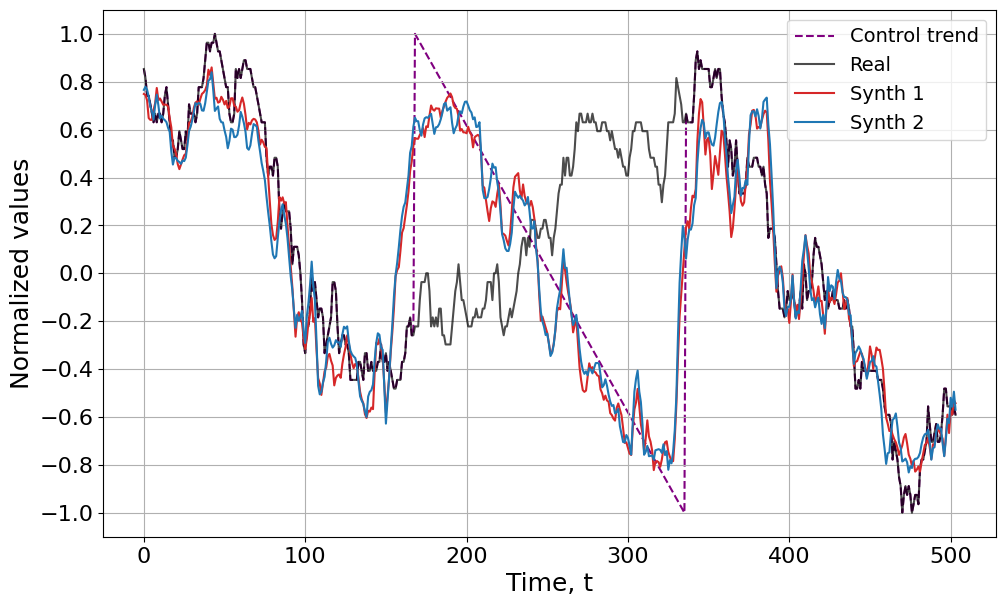

In [ ]:
plt.subplots(figsize=(10, 6))

plt.plot(control_trend.cpu()[idx][0], '--', color='purple', label='Control trend', zorder=1)
plt.plot(data[idx], label='Real', color='black', alpha=0.7, zorder=2)
plt.plot(synth_ts[0], label='Synth 1', color='tab:red', zorder=3)
plt.plot(synth_ts[1], label='Synth 2', color='tab:blue', zorder=3)
# plt.plot([0, 50], [0.3, 0.3])

plt.grid(True)
plt.xlabel('Time, t')
plt.ylabel('Normalized values')
plt.yticks(np.linspace(-1, 1, int(2/0.2+1)))
plt.legend()
plt.tight_layout(pad=0.5)
plt.show()

# Controlled generation evaluation

In [ ]:
!pip install fastdtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542089 sha256=e97603de87e3efe969a09577315d864d8f74e4809994e22e1e8b8422bb5d2835
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [ ]:
import scipy.stats as sts

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sts.sem(a)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [ ]:
from scipy.fft import fft

def find_dominant_frequencies(time_series, sample_rate):
    """
    Finds the dominant frequencies in a time series.

    Args:
      time_series: A 1D numpy array representing the time series data.
      sample_rate: The sampling rate of the time series (samples per unit time).

    Returns:
      A tuple containing:
        - frequencies: A numpy array of frequencies corresponding to the FFT output.
        - magnitudes: A numpy array of the magnitudes of the FFT output.
        - dominant_frequency: The frequency with the highest magnitude.
    """
    N = len(time_series)
    yf = fft(time_series)
    xf = np.fft.fftfreq(N, 1 / sample_rate)
    magnitudes = np.abs(yf)

    # Find the index of the maximum magnitude (excluding the DC component at index 0)
    max_magnitude_index = np.argmax(magnitudes[1:N // 2]) + 1
    dominant_frequency = xf[max_magnitude_index]

    return xf[0:N // 2], magnitudes[0:N // 2], dominant_frequency

In [ ]:
# control_trend = torch.tensor(torch.linspace(1, -1, T).to(device).view(1, -1).repeat(len(data), 1)).float().unsqueeze(1).to(device)
# control_trend = 0.5 * torch.tensor(torch.sin(torch.tensor(3*2*torch.pi*np.arange(len(data[0])))/len(data[0])).to(device)).view(1, -1).repeat(len(data), 1).float().unsqueeze(1).to(device)
end_point_control = -0.2 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)
start_point_control = 0.3 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)

lr_coef_all = []
corr_coef_all = []
dtw_all = []
fft_all = []
mse_all = []

for i in range(len(data)):
    # synth_ts = sample(n_samples, i, control_trend, control_trend.flatten()[-1].view(-1, 1, 1).repeat(len(data),1, 1),
    #                 control_trend.flatten()[0].view(-1, 1, 1).repeat(len(data),1, 1))
    synth_ts = sample(n_samples, i, hankel_td, end_point_control, start_point)
    # synth_ts = sample(n_samples, i, hankel_td, end_point, start_point)
    # synth_ts = sample(n_samples, i, hankel_td, end_point, start_point, ft=50, fv=0.4, fv_flag=True)

    lr_coef_arr = []
    corr_coef_arr = []
    dtw_arr = []
    fft_arr = []
    mse_arr = []

    for j in range(n_samples):
        lr = LinearRegression()
        lr.fit(np.linspace(0, 1, T).reshape(-1, 1), synth_ts[j].reshape(-1, 1))
        lr_coef_arr.append(lr.coef_[0][0])


        corr_coef_arr.append(np.corrcoef(control_trend[i].detach().cpu().numpy()[0],
                                         torch.vmap(smooth_fun_vectorized)(torch.tensor(synth_ts[j]).view(1, 1, 1, -1)).cpu().numpy().flatten())[0][1])

        # distance, _ = fastdtw(control_trend[i].detach().cpu().numpy()[0].reshape(-1, 1),
        #                       torch.vmap(smooth_fun_vectorized)(torch.tensor(synth_ts[j]).view(1, 1, 1, -1)).cpu().numpy().flatten().reshape(-1, 1), dist=euclidean)
        distance, _ = fastdtw(data[i].detach().cpu().numpy()[0].reshape(-1, 1),
                              synth_ts[j].flatten().reshape(-1, 1), dist=euclidean)

        dtw_arr.append(distance)
        fft_arr.append(find_dominant_frequencies(synth_ts[j], T)[2])

        mse_arr.append((-0.2 - synth_ts[j][-1])**2)

    lr_coef_all.append(np.mean(lr_coef_arr))
    corr_coef_all.append(np.mean(corr_coef_arr))
    dtw_all.append(np.mean(dtw_arr))
    fft_all.append(np.mean(fft_arr))
    mse_all.append(np.mean(mse_arr))

In [ ]:
mean_confidence_interval(lr_coef_all), np.std(lr_coef_all)

((np.float64(0.544302926347742), np.float64(0.23088263975149778)),
 np.float64(0.8042388502802521))

In [ ]:
mean_confidence_interval(corr_coef_all), np.std(corr_coef_all)

((np.float64(-0.366710836346498), np.float64(0.15908391439303746)),
 np.float64(0.5541406861392597))

In [ ]:
mean_confidence_interval(dtw_all)

(np.float64(278.3176752058266), np.float64(31.39505365591675))

In [ ]:
mean_confidence_interval(fft_all)

(np.float64(1.3238709677419354), np.float64(0.17667309218316823))

In [ ]:
mean_confidence_interval(mse_all)

(np.float32(0.008546656), np.float64(0.0016730546582620224))

In [ ]:
fft_arr = []
for i in range(len(data)):
  fft_arr.append(find_dominant_frequencies(data[i], T)[2])
mean_confidence_interval(fft_arr)

(np.float64(1.2), np.float64(0.140640969448547))

In [ ]:
lr_coef_all = []

for i in range(len(data)):
    lr = LinearRegression()
    lr.fit(np.linspace(0, 1, T).reshape(-1, 1), data[i].reshape(-1, 1))
    lr_coef_all.append(lr.coef_[0][0])

In [ ]:
np.array(lr_coef_all).mean(), np.array(lr_coef_all).std()

(np.float64(0.6664536629646252), np.float64(0.983823069935219))

In [ ]:
# lr_coef_arr = []
# for i in range(n_samples):
#   lr = LinearRegression()
#   lr.fit(np.linspace(0, 1, T).reshape(-1, 1), synth_ts[i].reshape(-1, 1))
#   lr_coef_arr.append(lr.coef_[0][0])

# print(f'{np.mean(lr_coef_arr)} +- {np.std(lr_coef_arr)}')

In [ ]:
lr = LinearRegression()
lr.fit(np.linspace(0, 1, T).reshape(-1, 1), control_trend.detach().cpu().numpy()[idx].reshape(-1, 1))
lr.coef_

array([[-0.31764254]])

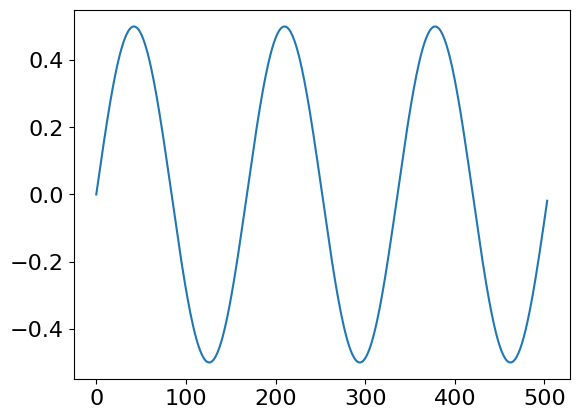

In [ ]:
plt.plot(control_trend[0][0].detach().cpu().numpy())

In [ ]:
corr_coef_arr = []

for i in range(n_samples):
  corr_coef_arr.append(np.corrcoef(control_trend[idx].detach().cpu().numpy()[0], synth_ts[i])[0][1])

print(f'{np.mean(corr_coef_arr)} +- {np.std(corr_coef_arr)}')

0.4926998150322368 +- 0.020585031759253445


In [ ]:
end_point_control = 0.5 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)
start_point_control = 0.5 * torch.ones((len(data), 1, 1), dtype=torch.float32).to(device)
# idx_arr = np.linspace(0, 31, 1).astype(int)

ep_err_arr = []
sp_err_arr = []

for i in range(len(data)):
  synth_ts_ep = sample(n_samples, i, hankel_td, end_point_control, start_point)[:, -1]
  synth_ts_sp = sample(n_samples, i, hankel_td, end_point, start_point_control)[:, 0]

  ep_err_arr.append((np.mean(synth_ts_ep) - data.numpy()[i, -1])**2)
  sp_err_arr.append((np.mean(synth_ts_sp) - data.numpy()[i, 0])**2)

print(f'{np.mean(ep_err_arr)} +- {np.std(ep_err_arr)}')
print(f'{np.mean(sp_err_arr)} +- {np.std(sp_err_arr)}')

0.08149365335702896 +- 0.09977718442678452
0.12943024933338165 +- 0.08327922970056534


In [ ]:
synth_ts = sample(n_samples, idx, hankel_td, end_point, start_point, ft=400, fv=0.1, fv_flag=False)
synth_ts[np.where(synth_ts < -1)] = -1
synth_ts[np.where(synth_ts > 1)] = 1

In [ ]:
synth_data = []
n_samples = 31

for i in range(len(data)):
  synth_ts = sample(n_samples, i, hankel_td, end_point, start_point, ft=400, fv=0.1, fv_flag=False)
  synth_ts[np.where(synth_ts < -1)] = -1
  synth_ts[np.where(synth_ts > 1)] = 1
  synth_data.append(synth_ts)

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance, moment, ks_2samp
from scipy.spatial.distance import jensenshannon
from scipy.signal import periodogram

def calc_metrics(data, synth):

    trial_metrics_mean = []

    for i in range(len(data)):

        wd_arr = []
        djs_arr = []
        tv_arr = []
        moments_arr = []
        dtw_arr = []

        for j in range(31):

            wd_arr.append(wasserstein_distance(data[i].numpy(), synth[i][j]))

            data_combined = np.concatenate([data[i].numpy(), synth[i][j]])
            bins = np.histogram_bin_edges(data_combined, bins='auto')
            hist_real, _ = np.histogram(data[i].numpy(), bins=bins, density=True)
            hist_synthetic, _ = np.histogram(synth[i][j], bins=bins, density=True)

            # Add small epsilon to avoid log(0)
            epsilon = 1e-10
            hist_real += epsilon
            hist_synthetic += epsilon
            hist_real /= hist_real.sum()
            hist_synthetic /= hist_synthetic.sum()
            djs_arr.append(jensenshannon(hist_real, hist_synthetic))

            # djs_arr.append(jensenshannon(np.abs(data[i].numpy()), np.abs(synth_FF_arr[i][j])))

            hist_real, _ = np.histogram(data[i].numpy(), bins=bins, density=True)
            hist_real /= hist_real.sum()
            hist_syn, _ = np.histogram(synth[i][j], bins=bins, density=True)
            hist_syn /= hist_syn.sum()
            tv_arr.append(0.5 * np.sum(np.abs(hist_real - hist_syn)))

            moments_real = [moment(data[i].numpy(), moment=k) for k in range(1,4)]
            moments_syn = [moment(synth[i][j], moment=k) for k in range(1,4)]
            moment_diff = np.mean(np.abs(np.array(moments_real) - np.array(moments_syn)))
            moments_arr.append(moment_diff)

            distance, _ = fastdtw(data[i].reshape(-1, 1), synth[i][j].reshape(-1, 1), dist=euclidean)
            dtw_arr.append(distance)



        trial_metrics_mean.append([np.mean(wd_arr), np.mean(djs_arr), np.mean(tv_arr), np.mean(moments_arr), np.mean(dtw_arr)])

    trial_metrics_mean = np.array(trial_metrics_mean)

    return trial_metrics_mean

trial_metrics_mean = calc_metrics(data, synth_data)

In [ ]:
import scipy.stats as sts

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sts.sem(a)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return m, h


for i in range(5):
    print(mean_confidence_interval(trial_metrics_mean[:, i]))

(np.float64(0.05001423586341589), np.float64(0.004003322945507662))
(np.float64(0.21243673055748163), np.float64(0.01601974137846713))
(np.float64(0.2055632381123832), np.float64(0.01775181989318996))
(np.float64(0.01368988494388759), np.float64(0.0021475919885165927))
(np.float64(27.686091335252037), np.float64(1.5439977115042374))
